In [1]:
!pip install category_encoders
!pip install catboost

     |████████████████████████████████| 86 kB 3.0 MB/s 
     |████████████████████████████████| 76.6 MB 1.4 MB/s 


In [2]:
# Load all helper function
%run -i '../util/helper.py'

In [3]:
import pandas as pd

# Load Dataset and Data Split

In [4]:
df  = pd.read_csv('../Dataset/brazilian_ecommerce_encoded.csv')
y = df["is_delayed"]
X = df.drop(["is_delayed"], axis=1, inplace=False)

In [5]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2, stratify=y)

In [6]:
print(X_dev.shape)
print(X_test.shape)

(92506, 30)
(23127, 30)


# Hyperparameter Tuning

## Stratified Sampling

### GridSearch

In [7]:
learning_rate = [0.05,0.1,0.15]
n_estimators = [100,200,300]
depth = [6,8,10]
start4 = time()

parameter_grid = {'classifier__n_estimators':n_estimators,'classifier__learning_rate': learning_rate,'classifier__max_depth':depth}

pipe_CB_tune = Pipeline([('classifier',CatBoostClassifier(random_state=random_state))])

pipe_CB = make_pipeline(GridSearchCV(pipe_CB_tune,
                                      param_grid=parameter_grid,
                                      return_train_score=True,
                                      cv=StratifiedKFold(n_splits=10,shuffle=False),
                                      n_jobs=-1, 
                                      scoring=['recall','f1'],
                                      refit='f1'))
pipe_CB.fit(X_dev, np.ravel(y_dev))
end4 = time()
print("CatBoost model takes " + str(end4-start4) + "seconds")

0:	learn: 0.6233738	total: 75.2ms	remaining: 7.44s
1:	learn: 0.5717696	total: 104ms	remaining: 5.1s
2:	learn: 0.5225638	total: 130ms	remaining: 4.21s
3:	learn: 0.4785330	total: 157ms	remaining: 3.78s
4:	learn: 0.4426450	total: 184ms	remaining: 3.5s
5:	learn: 0.4130681	total: 213ms	remaining: 3.33s
6:	learn: 0.3876097	total: 241ms	remaining: 3.2s
7:	learn: 0.3644688	total: 270ms	remaining: 3.1s
8:	learn: 0.3436317	total: 302ms	remaining: 3.06s
9:	learn: 0.3254612	total: 331ms	remaining: 2.98s
10:	learn: 0.3113275	total: 356ms	remaining: 2.88s
11:	learn: 0.2992051	total: 384ms	remaining: 2.82s
12:	learn: 0.2865879	total: 413ms	remaining: 2.76s
13:	learn: 0.2788660	total: 440ms	remaining: 2.7s
14:	learn: 0.2693440	total: 471ms	remaining: 2.67s
15:	learn: 0.2611111	total: 497ms	remaining: 2.61s
16:	learn: 0.2538149	total: 529ms	remaining: 2.58s
17:	learn: 0.2477231	total: 556ms	remaining: 2.53s
18:	learn: 0.2443156	total: 586ms	remaining: 2.5s
19:	learn: 0.2392709	total: 613ms	remaining: 2

In [25]:
def str2bool(v):
  return v.lower() in ("yes", "true", "t", "1")

In [26]:
grid_search_CB = pipe_CB.named_steps["gridsearchcv"]
print(f"The CatBoost model Best hyperparameters is ", grid_search_CB.best_params_)

The CatBoost model Best hyperparameters is  {'classifier__learning_rate': 0.05, 'classifier__max_depth': 6, 'classifier__n_estimators': 100}


### Evaluate on the Test Set

In [27]:
CB_prediction = np.array([str2bool(p) for p in pipe_CB.predict(X_test)])

print(f'Accuracy: {accuracy_score(y_test,CB_prediction)}')
print(f'Recall: {recall_score(y_test,CB_prediction)}')
print(f'Precision: {precision_score(y_test,CB_prediction)}')
print(f'F-1 Score: {f1_score(y_test,CB_prediction)}')

recall, precision = recall_score(y_test,CB_prediction), precision_score(y_test,CB_prediction)

Accuracy: 0.9382107493405976
Recall: 0.2495697074010327
Precision: 0.7823741007194245
F-1 Score: 0.3784254023488473


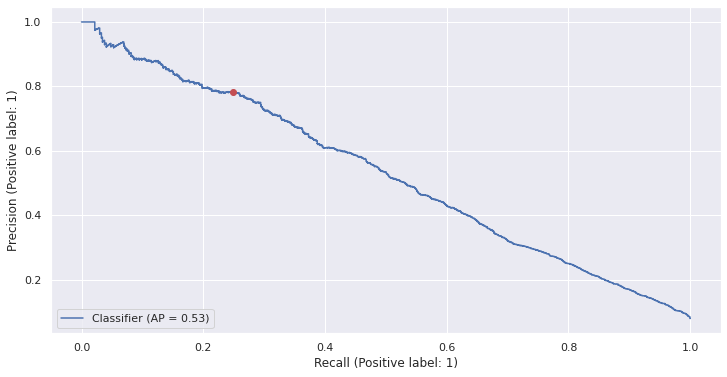

In [32]:
probs = pipe_CB.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

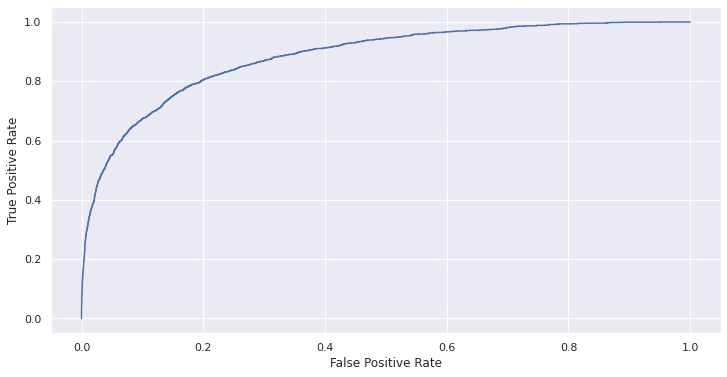

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

In [35]:
filename = '../model/CatBoost_stratified.sav'
pickle.dump(pipe_CB, open(filename, 'wb'))

## Downsampling

In [36]:
rus = RandomUnderSampler(replacement=False, random_state=random_state)
X_dev_us, y_dev_us = rus.fit_resample(X_dev, y_dev)

### GridSearch

In [37]:
learning_rate = [0.05,0.1,0.15]
n_estimators = [100,200,300]
depth = [6,8,10]
start5 = time()

parameter_grid = {'classifier__n_estimators':n_estimators,'classifier__learning_rate': learning_rate,'classifier__max_depth':depth}
pipe_CB_tune = Pipeline([('classifier',CatBoostClassifier(random_state=random_state))])
pipe_CB = make_pipeline(GridSearchCV(pipe_CB_tune,
                                      param_grid=parameter_grid,
                                      return_train_score=True,
                                      cv=StratifiedKFold(n_splits=10,shuffle=False),
                                      n_jobs=-1, 
                                      scoring=['recall','f1'],
                                      refit='f1'))
pipe_CB.fit(X_dev_us, np.ravel(y_dev_us))
end5 = time()
print("CatBoost model takes " + str(end5-start5) + "seconds")

0:	learn: 0.6747757	total: 9.17ms	remaining: 908ms
1:	learn: 0.6563478	total: 17.7ms	remaining: 866ms
2:	learn: 0.6394946	total: 26.2ms	remaining: 847ms
3:	learn: 0.6256803	total: 34.5ms	remaining: 829ms
4:	learn: 0.6129460	total: 42.9ms	remaining: 815ms
5:	learn: 0.6013534	total: 51ms	remaining: 800ms
6:	learn: 0.5913431	total: 59.8ms	remaining: 794ms
7:	learn: 0.5815660	total: 68.1ms	remaining: 783ms
8:	learn: 0.5712939	total: 76.3ms	remaining: 771ms
9:	learn: 0.5637271	total: 84.5ms	remaining: 760ms
10:	learn: 0.5557687	total: 93.2ms	remaining: 754ms
11:	learn: 0.5497460	total: 102ms	remaining: 749ms
12:	learn: 0.5449925	total: 111ms	remaining: 744ms
13:	learn: 0.5398694	total: 119ms	remaining: 733ms
14:	learn: 0.5345762	total: 128ms	remaining: 725ms
15:	learn: 0.5303604	total: 137ms	remaining: 717ms
16:	learn: 0.5265281	total: 145ms	remaining: 708ms
17:	learn: 0.5219135	total: 154ms	remaining: 702ms
18:	learn: 0.5193755	total: 163ms	remaining: 693ms
19:	learn: 0.5150202	total: 171m

In [38]:
grid_search_CB = pipe_CB.named_steps["gridsearchcv"]
print(f"The CatBoost model Best hyperparameters is ", grid_search_CB.best_params_)

The CatBoost model Best hyperparameters is  {'classifier__learning_rate': 0.05, 'classifier__max_depth': 6, 'classifier__n_estimators': 100}


### Evaluate on the Test Set

In [39]:
CB_prediction = np.array([str2bool(p) for p in pipe_CB.predict(X_test)])

print(f'Accuracy: {accuracy_score(y_test,CB_prediction)}')
print(f'Recall: {recall_score(y_test,CB_prediction)}')
print(f'Precision: {precision_score(y_test,CB_prediction)}')
print(f'F-1 Score: {f1_score(y_test,CB_prediction)}')

recall, precision = recall_score(y_test,CB_prediction), precision_score(y_test,CB_prediction)

Accuracy: 0.8226315561897349
Recall: 0.774526678141136
Precision: 0.2668511563550109
F-1 Score: 0.39694207586004115


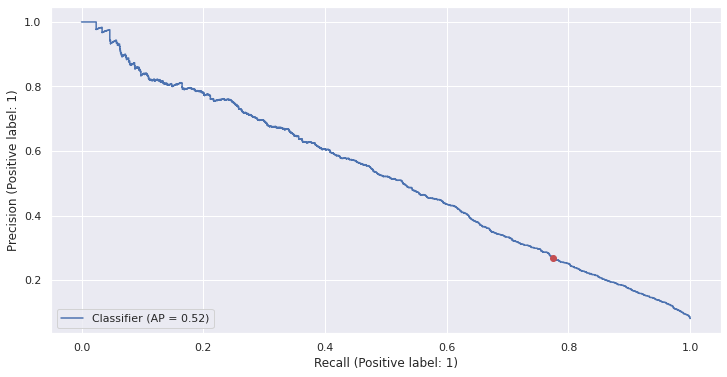

In [45]:
probs = pipe_CB.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

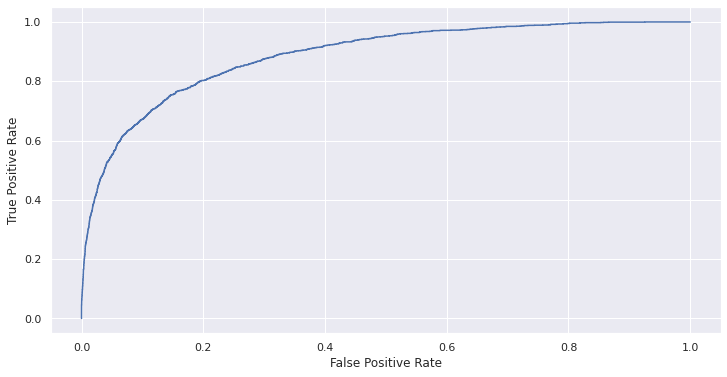

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

In [47]:
filename = '../model/CatBoost_downsampling.sav'
pickle.dump(pipe_CB, open(filename, 'wb'))